## import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
#image augmentation 지원
import  albumentations  as A
from  albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


/home/hufsbme/anaconda3/envs/infant/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/hufsbme/anaconda3/envs/infant/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
!nvidia-smi

Tue Jul 11 04:26:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:01:00.0 Off |                  N/A |
| 51%   71C    P0    75W / 250W |      2MiB / 12194MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## utils

In [4]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


## custom dataset

In [72]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, validation = False,infer=False,train_ratio = 0.8):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.train_ratio = train_ratio
#         if self.infer == False:
            
#             train_data, valid_data = train_test_split(self.data,train_size=self.train_ratio,random_state=42)
#             if validation:
#                 self.data = valid_data
#             else:
#                 self.data = train_data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        

        
        if self.infer:
            index = self.data.iloc[idx, 1].split('/')[2]
            img_path = '/nfs/hufsaims/kjh_shared/euna/open/test_img/' + index
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        else:
            index = self.data.iloc[idx, 1].split('/')[2]
            img_path = '/nfs/hufsaims/kjh_shared/euna/open/train_img/' + index
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask
                

In [49]:
# data = pd.read_csv('/nfs/hufsaims/kjh_shared/euna/open/test.csv')
# img = data.iloc[1,1].split('/')[2]
# img
# img_path = '/nfs/hufsaims/kjh_shared/euna/open/test_img/' + img
# img_path
# image = cv2.imread(img_path)
# image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# image.shape
# mask_rle = data.iloc[1,2]
mask_rle

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f99a5eaf250>
Traceback (most recent call last):
  File "/home/hufsbme/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/home/hufsbme/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
  File "/home/hufsbme/anaconda3/envs/infant/lib/python3.10/multiprocessing/process.py", line 149, in join
  File "/home/hufsbme/anaconda3/envs/infant/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
  File "/home/hufsbme/anaconda3/envs/infant/lib/python3.10/multiprocessing/connection.py", line 931, in wait
  File "/home/hufsbme/anaconda3/envs/infant/lib/python3.10/selectors.py", line 416, in select
KeyboardInterrupt: 


IndexError: index 2 is out of bounds for axis 0 with size 2

In [7]:
data = pd.read_csv('/nfs/hufsaims/kjh_shared/euna/open/train.csv')
train = len(data) * 0.8


## data Loader

In [8]:
transform = A.Compose(
[
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
])
import glob as glob
#csv 파일 (7140,3)
data_dir = glob.glob(os.path.join('/nfs/hufsaims/kjh_shared/euna/open/train.csv'))

train_dataset = SatelliteDataset(csv_file='/nfs/hufsaims/kjh_shared/euna/open/train.csv',transform = transform,infer = False,train_ratio=0.8)
valid_dataset = SatelliteDataset(csv_file='/nfs/hufsaims/kjh_shared/euna/open/train.csv',transform = transform,validation = True, infer = False,train_ratio=0.8)

train_dataloader = DataLoader(train_dataset, batch_size=16,shuffle = True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset,batch_size=16,shuffle = False,num_workers=2)

In [9]:
data_dir = glob.glob(os.path.join('/nfs/hufsaims/kjh_shared/euna/open/train.csv'))
data_dir

['/nfs/hufsaims/kjh_shared/euna/open/train.csv']

In [10]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        #in_channels, out_channels,kernel_size
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3,64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        x = self.dconv_down4(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [11]:
import torch.nn.functional as F

#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [12]:
model = UNet().to(device)

criterion = DiceLoss()
optimizer= torch.optim.Adam(model.parameters(),lr = 0.001)
epoch_loss = []
epoch_val_loss = []
for epoch in range(50):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}')
    if (epoch+1)%5 == 0:
        model.eval()
        valid_loss= 0
        with torch.no_grad():
            for images, masks in valid_dataloader:
                images = images.float().to(device)
                masks = masks.float().to(device)
                
                outputs= model(images)
                loss = criterion(outputs,masks.unsqueeze(1))
                valid_loss += loss.item()
        print(f'Epoch {epoch+1}, Valid_Loss: {valid_loss/len(valid_dataloader)}')


  0%|                                                   | 0/357 [00:00<?, ?it/s]/home/hufsbme/.local/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 1, Loss: 0.6448361778459629


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.56it/s]


Epoch 2, Loss: 0.5587139099585909


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 3, Loss: 0.4651279145596074


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.56it/s]


Epoch 4, Loss: 0.39413975083193525


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.56it/s]

Epoch 5, Loss: 0.36555284061351745


Epoch 5, Valid_Loss: 0.3502858155303531


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.56it/s]


Epoch 6, Loss: 0.34579183791531903


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 7, Loss: 0.3302035039546443


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.56it/s]


Epoch 8, Loss: 0.316344725150688


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 9, Loss: 0.30873151436573315


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.56it/s]

Epoch 10, Loss: 0.2997826776918577


Epoch 10, Valid_Loss: 0.32168106238047284


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 11, Loss: 0.2982049474195272


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 12, Loss: 0.28623317102758156


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 13, Loss: 0.282783035470658


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 14, Loss: 0.2784104772976467


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]

Epoch 15, Loss: 0.2735590305315012


Epoch 15, Valid_Loss: 0.27693744500478107


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 16, Loss: 0.2701578956692159


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 17, Loss: 0.2690073730898838


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 18, Loss: 0.2663674534869795


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 19, Loss: 0.2607193988244407


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]

Epoch 20, Loss: 0.26168868838905956


Epoch 20, Valid_Loss: 0.27417613599035473


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 21, Loss: 0.25511983145518796


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 22, Loss: 0.25218447299898505


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 23, Loss: 0.2513951467198818


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 24, Loss: 0.24981248662585304


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.52it/s]

Epoch 25, Loss: 0.24709211761544064


Epoch 25, Valid_Loss: 0.2657059854931302


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 26, Loss: 0.24632457090693027


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 27, Loss: 0.2467959099123124


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 28, Loss: 0.24241109722468698


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 29, Loss: 0.2430561894462222


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]

Epoch 30, Loss: 0.2397319879852423


Epoch 30, Valid_Loss: 0.25023403631316293


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 31, Loss: 0.23941728497753625


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 32, Loss: 0.2364330911168865


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 33, Loss: 0.2346209185797961


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 34, Loss: 0.2355425646659039


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]

Epoch 35, Loss: 0.23405112989810334


Epoch 35, Valid_Loss: 0.24401381015777587


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 36, Loss: 0.23124844453581908


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 37, Loss: 0.22828613025467603


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 38, Loss: 0.22962689332935324


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 39, Loss: 0.2294004960220401


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]

Epoch 40, Loss: 0.22553664813188612


Epoch 40, Valid_Loss: 0.24868945810529922


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.55it/s]


Epoch 41, Loss: 0.22408254407033198


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 42, Loss: 0.2254100632266838


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 43, Loss: 0.22168002659533204


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 44, Loss: 0.223999017093028


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]

Epoch 45, Loss: 0.22194849559906818


Epoch 45, Valid_Loss: 0.23798882365226745


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.52it/s]


Epoch 46, Loss: 0.21857445580618723


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]


Epoch 47, Loss: 0.21765115514856762


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.52it/s]


Epoch 48, Loss: 0.21759443440023257


100%|█████████████████████████████████████████| 357/357 [01:40<00:00,  3.54it/s]


Epoch 49, Loss: 0.2159413182768835


100%|█████████████████████████████████████████| 357/357 [01:41<00:00,  3.53it/s]

Epoch 50, Loss: 0.21553947912210844


Epoch 50, Valid_Loss: 0.23763808475600348


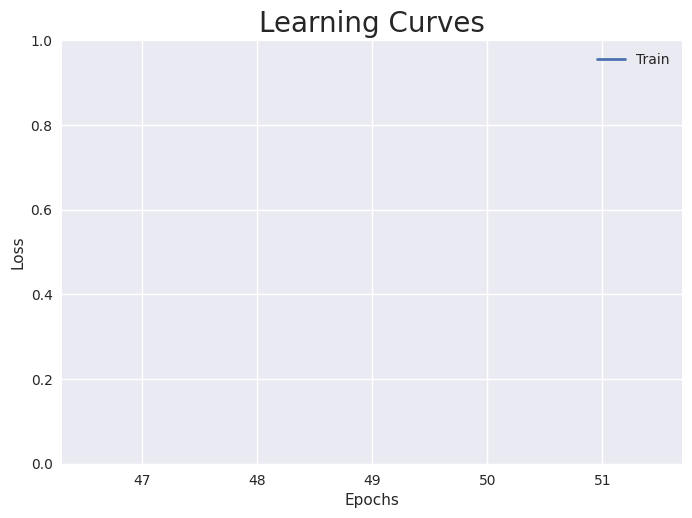

In [20]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(epoch, epoch_loss, color="C0", linewidth=2.0, label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0,1])
plt.legend(loc='upper right')
plt.show()

In [79]:
class SatelliteDataset2(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        index = self.data.iloc[idx, 1].split('/')[2]
        img_path = '/nfs/hufsaims/kjh_shared/euna/open/test_img/'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
data = pd.read_csv('/nfs/hufsaims/kjh_shared/euna/open/test.csv')
index = data.iloc[idx,1].split('/')[2]
index

In [80]:
test_dataset = SatelliteDataset2(csv_file='/nfs/hufsaims/kjh_shared/euna/open/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [81]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        
        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

  0%|                                                  | 0/3790 [00:00<?, ?it/s]


error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/hufsbme/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/hufsbme/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/hufsbme/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_1633658/2340593905.py", line 14, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



In [74]:
submit = pd.read_csv('/nfs/hufsaims/kjh_shared/euna/open/sample_submission.csv')

In [75]:
submit['mask_rle'] = result

ValueError: Length of values (48512) does not match length of index (60640)

In [68]:
result

['45 9 266 12 455 1 490 11 532 2 677 3 713 13 756 2 899 6 931 1 938 12 1123 6 1163 11 1348 1 1350 1 1574 1 4761 6 4985 6 5209 6 5433 4 6725 6 6949 8 7173 8 7397 9 7621 9 7849 3 21229 3 21453 3 21676 4 21899 4 22123 4 22347 3 22571 2 22795 2 23019 2 23479 6 23702 8 23926 8 23937 3 23999 1 24149 11 24162 2 24222 20 24373 12 24387 1 24433 1 24446 21 24595 18 24654 5 24670 22 24819 17 24877 6 24894 22 25043 17 25267 17 25485 4 25492 15 25709 6 25718 12 25933 7 25943 9 26003 1 26143 6 26156 8 26168 7 26364 12 26380 8 26392 7 26588 12 26601 11 26614 1 26616 6 26661 1 26811 25 26838 4 26885 1 27035 25 27061 6 27108 2 27258 33 27332 2 27481 35 27557 1 27704 36 27924 40 28146 40 28370 39 28592 39 28817 37 28982 4 29041 38 29206 4 29265 37 29431 4 29489 36 29713 35 29935 36 30159 36 30381 1 30383 34 30605 34 30828 35 31050 36 31272 37 31496 37 31720 37 31934 3 31940 40 32158 44 32382 44 32595 2 32603 46 32818 7 32826 46 33042 7 33051 44 33266 3 33271 2 33275 44 33489 8 33502 40 33713 8 33727 38 